In [1]:
!pip install shap

     |████████████████████████████████| 327kB 8.4MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456464 sha256=2573799e060c7e982ec76cb2a9f0378901bd266cad82677263825fa80502c674
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


Importing Libraries

In [71]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler

In [72]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebook/Shap Demo/taskdata.csv")
df.head()

,user_id,account_id,max_return_days,average_return_days,customer_since_months,total_revenue,average_revenue,avg_vas_count,avg_used_vas_value,business_type,avg_wallet_bonus,avg_active_ads,avg_new_ads,avg_email_replies,avg_call_replies,avg_sms_replies,target
0,410039,496.0,8,1.500000,14,0.0,0.0,3.666667,66.666667,0,300.0,79.333333,15.250000,32.416667,27.916667,0.250000,0
1,410240,499.0,37,8.200000,10,0.0,0.0,4.900000,114.000000,0,0.0,232.100000,18.300000,16.200000,13.800000,0.000000,0
2,411764,493.0,9,1.533333,15,0.0,0.0,5.333333,106.666667,0,150.0,55.083333,3.750000,20.250000,24.500000,0.000000,0
3,411985,262.0,1,1.000000,14,0.0,0.0,6.307692,176.153846,0,1481.0,409.538462,80.769231,87.461538,57.615385,0.000000,1
4,412071,496.0,1,1.000000,18,0.0,0.0,5.846154,109.230769,0,41.5,48.230769,1.692308,17.461538,25.769231,0.230769,0


In [73]:
df.isnull().sum()

user_id                  0
account_id               7
max_return_days          0
average_return_days      0
customer_since_months    0
total_revenue            0
average_revenue          0
avg_vas_count            0
avg_used_vas_value       0
business_type            0
avg_wallet_bonus         0
avg_active_ads           0
avg_new_ads              0
avg_email_replies        0
avg_call_replies         0
avg_sms_replies          0
target                   0
dtype: int64

Dropping the rows with missing values

In [74]:
df.dropna(inplace=True)
df.reset_index()

,index,user_id,account_id,max_return_days,average_return_days,customer_since_months,total_revenue,average_revenue,avg_vas_count,avg_used_vas_value,business_type,avg_wallet_bonus,avg_active_ads,avg_new_ads,avg_email_replies,avg_call_replies,avg_sms_replies,target
0,0,410039,496.0,8,1.500000,14,0.00,0.00,3.666667,66.666667,0,300.0,79.333333,15.250000,32.416667,27.916667,0.250000,0
1,1,410240,499.0,37,8.200000,10,0.00,0.00,4.900000,114.000000,0,0.0,232.100000,18.300000,16.200000,13.800000,0.000000,0
2,2,411764,493.0,9,1.533333,15,0.00,0.00,5.333333,106.666667,0,150.0,55.083333,3.750000,20.250000,24.500000,0.000000,0
3,3,411985,262.0,1,1.000000,14,0.00,0.00,6.307692,176.153846,0,1481.0,409.538462,80.769231,87.461538,57.615385,0.000000,1
4,4,412071,496.0,1,1.000000,18,0.00,0.00,5.846154,109.230769,0,41.5,48.230769,1.692308,17.461538,25.769231,0.230769,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,4402,73498690100,113.0,1,1.000000,4,0.00,0.00,0.000000,0.000000,3,0.0,4.666667,2.000000,9.666667,14.666667,0.333333,0
4396,4403,73519239100,1017.0,1,1.000000,2,0.00,0.00,0.000000,0.000000,4,0.0,153.000000,76.500000,9.000000,11.500000,0.000000,0
4397,4404,73525763100,226.0,1,1.000000,2,0.00,0.00,0.000000,0.000000,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0
4398,4405,73538605100,226.0,1,1.000000,2,551.19,551.19,7.000000,70.000000,1,0.0,17.000000,17.000000,10.000000,8.000000,0.000000,0


In [75]:
print("Unique accounts : ",df['account_id'].nunique())
print("Unique Users : ",df['user_id'].nunique() )

Unique accounts :  15
Unique Users :  4400


In [76]:
df['account_id'].value_counts()

1005.0    684
493.0     483
499.0     467
496.0     467
262.0     438
1017.0    436
113.0     290
226.0     275
111.0     248
112.0     148
364.0     134
517.0     112
202.0     111
115.0      73
116.0      34
Name: account_id, dtype: int64

In [77]:
df.shape

(4400, 17)

In [78]:
df.index = df['user_id']
df.drop('user_id',axis=1,inplace=True)
df.head()

,account_id,max_return_days,average_return_days,customer_since_months,total_revenue,average_revenue,avg_vas_count,avg_used_vas_value,business_type,avg_wallet_bonus,avg_active_ads,avg_new_ads,avg_email_replies,avg_call_replies,avg_sms_replies,target
user_id,,,,,,,,,,,,,,,,
410039,496.0,8,1.500000,14,0.0,0.0,3.666667,66.666667,0,300.0,79.333333,15.250000,32.416667,27.916667,0.250000,0
410240,499.0,37,8.200000,10,0.0,0.0,4.900000,114.000000,0,0.0,232.100000,18.300000,16.200000,13.800000,0.000000,0
411764,493.0,9,1.533333,15,0.0,0.0,5.333333,106.666667,0,150.0,55.083333,3.750000,20.250000,24.500000,0.000000,0
411985,262.0,1,1.000000,14,0.0,0.0,6.307692,176.153846,0,1481.0,409.538462,80.769231,87.461538,57.615385,0.000000,1
412071,496.0,1,1.000000,18,0.0,0.0,5.846154,109.230769,0,41.5,48.230769,1.692308,17.461538,25.769231,0.230769,0


In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
account_id,4400.0,506.553864,326.072756,111.0,226.000000,493.000000,1005.000000,1017.000000
max_return_days,4400.0,22.362500,43.618703,1.0,1.000000,2.000000,30.000000,354.000000
average_return_days,4400.0,7.174561,19.219665,0.5,1.000000,1.076923,5.666667,354.000000
customer_since_months,4400.0,9.884545,5.163509,1.0,5.000000,12.000000,14.000000,24.000000
total_revenue,4400.0,194.439208,1549.573607,0.0,0.000000,0.000000,0.000000,43957.172700
average_revenue,4400.0,16.969570,128.369056,0.0,0.000000,0.000000,0.000000,3852.727273
avg_vas_count,4400.0,3.253853,5.512943,0.0,0.153846,2.000000,4.358766,156.583333
avg_used_vas_value,4400.0,72.217150,117.082250,0.0,2.964286,45.000000,100.000000,3357.500000
business_type,4400.0,0.496591,1.198236,0.0,0.000000,0.000000,0.000000,5.000000
avg_wallet_bonus,4400.0,339.299218,832.312947,0.0,0.000000,41.500000,328.275000,15606.500000


In [80]:
df.corr()

,account_id,max_return_days,average_return_days,customer_since_months,total_revenue,average_revenue,avg_vas_count,avg_used_vas_value,business_type,avg_wallet_bonus,avg_active_ads,avg_new_ads,avg_email_replies,avg_call_replies,avg_sms_replies,target
account_id,1.000000,0.186045,0.114084,-0.138623,-0.056088,-0.063251,-0.123744,-0.137692,-0.023560,-0.115246,-0.104818,-0.049433,-0.111508,-0.115326,-0.082611,0.121939
max_return_days,0.186045,1.000000,0.749133,-0.187866,-0.001889,0.013184,-0.112382,-0.119129,-0.018485,-0.131552,-0.042902,-0.009146,-0.075940,-0.079302,-0.050359,0.275500
average_return_days,0.114084,0.749133,1.000000,-0.257220,-0.014447,-0.006567,-0.108128,-0.114067,0.027346,-0.103593,-0.047031,-0.017632,-0.070784,-0.070982,-0.038793,0.166119
customer_since_months,-0.138623,-0.187866,-0.257220,1.000000,0.090466,0.063811,0.320958,0.350325,-0.217427,0.351896,0.138805,0.020578,0.206001,0.206257,0.122789,-0.235238
total_revenue,-0.056088,-0.001889,-0.014447,0.090466,1.000000,0.950357,0.608638,0.642191,-0.017400,0.075885,0.341788,0.131101,0.214032,0.214258,0.213352,-0.032580
average_revenue,-0.063251,0.013184,-0.006567,0.063811,0.950357,1.000000,0.586291,0.612613,-0.001530,0.070007,0.354482,0.132759,0.209668,0.209233,0.214889,-0.025354
avg_vas_count,-0.123744,-0.112382,-0.108128,0.320958,0.608638,0.586291,1.000000,0.962294,-0.119417,0.130987,0.413871,0.192561,0.360600,0.342573,0.240456,-0.117154
avg_used_vas_value,-0.137692,-0.119129,-0.114067,0.350325,0.642191,0.612613,0.962294,1.000000,-0.119371,0.156046,0.407629,0.186521,0.362861,0.347016,0.244097,-0.128464
business_type,-0.023560,-0.018485,0.027346,-0.217427,-0.017400,-0.001530,-0.119417,-0.119371,1.000000,-0.107314,-0.076037,-0.004429,-0.050023,-0.053766,0.005707,0.005954
avg_wallet_bonus,-0.115246,-0.131552,-0.103593,0.351896,0.075885,0.070007,0.130987,0.156046,-0.107314,1.000000,0.256529,0.121930,0.273732,0.284304,0.237666,-0.076783


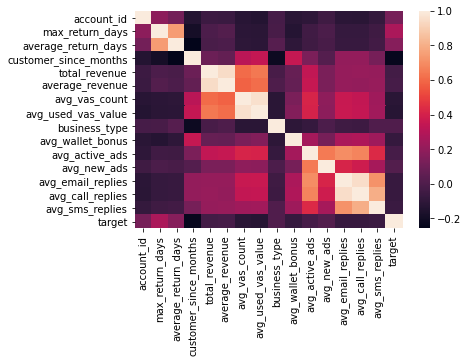

In [81]:
sns.heatmap(df.corr())


So Clearly the dataset is highly imbalanced dataset as can be seen from the below countplot

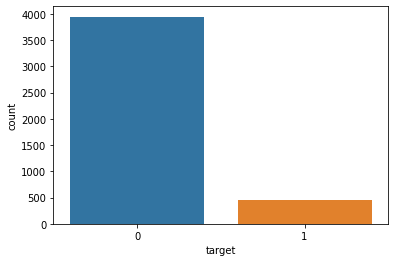

In [82]:
sns.countplot(data=df,x='target')

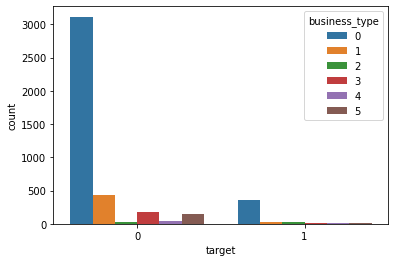

In [83]:
sns.countplot(data=df,x='target',hue='business_type')

1.   So From The 1st Graph We can that as the since month decreases it moves more towards 1.
2. Similarly From the 2nd Graph we can as the average return days increases people tend more more towards 1.  
3.   So in Graph 3 we can see at higher revenue the customer is mostly in 0 .
4.   In Graph 4 we can As the wallet bonus decreases the customer tend to be more more 1.


So From Here we can conclude that wallet bonus could be a good promotion at early stages. And once the customer has been with us for a long time . Then there is a less possibility that our would fall on cateogy  1 of target. 






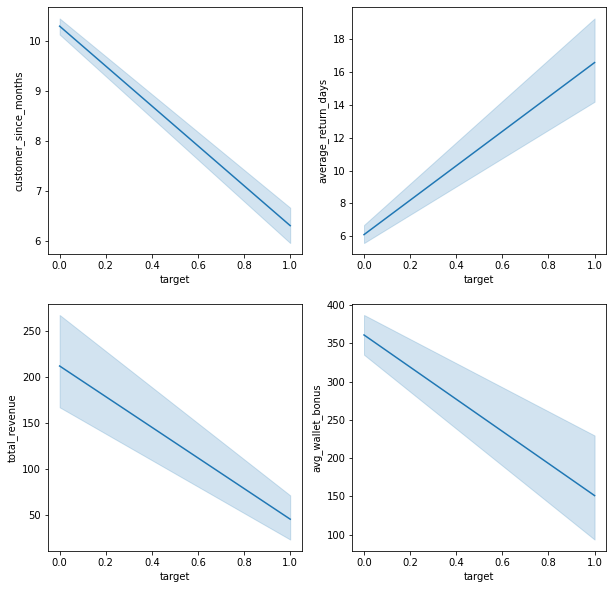

In [84]:
plt.figure(figsize=(10,10))
plt.tight_layout()
plt.subplot(2,2,1)
sns.lineplot(y=df['customer_since_months'],x=df['target'])
plt.subplot(2,2,2)
sns.lineplot(y=df['average_return_days'],x=df['target'])
plt.subplot(2,2,3)
sns.lineplot(y=df['total_revenue'],x=df['target'])
plt.subplot(2,2,4)
sns.lineplot(y=df['avg_wallet_bonus'],x=df['target'])

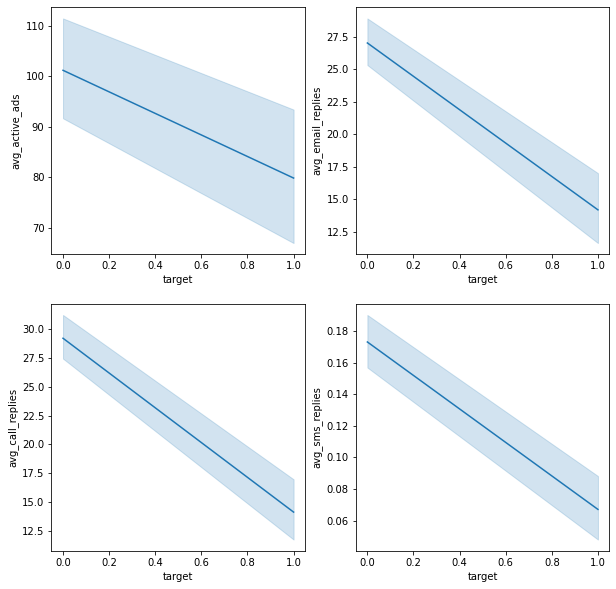

In [85]:
plt.figure(figsize=(10,10))
plt.tight_layout()
plt.subplot(2,2,1)
sns.lineplot(y=df['avg_active_ads'],x=df['target'])
plt.subplot(2,2,2)
sns.lineplot(y=df['avg_email_replies'],x=df['target'])
plt.subplot(2,2,3)
sns.lineplot(y=df['avg_call_replies'],x=df['target'])
plt.subplot(2,2,4)
sns.lineplot(y=df['avg_sms_replies'],x=df['target'])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


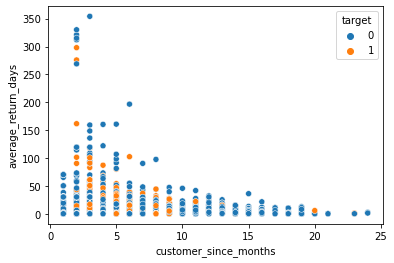

In [86]:
sns.scatterplot(df['customer_since_months'],df['average_return_days'],hue=df['target'])

Seprating the features and target variables in x and y repectively

In [87]:
x =df.iloc[:,:-1]
y= df.iloc[:,-1]

Spliting Train and Test data

In [88]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.25,stratify=y,random_state = 1)

Performing Over Sampling Because Dataset is Highly Imbalanced 

In [89]:

ros = RandomOverSampler(random_state=1,sampling_strategy='minority')
x_sm,y_sm = ros.fit_sample(x_train,y_train)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [90]:
x_train.shape, x_test.shape

((3300, 15), (1100, 15))

Scalling the Data

In [91]:
sc = StandardScaler()
x_sm= sc.fit_transform(x_sm)
x_test = sc.transform(x_test)

In [92]:
xgb =XGBClassifier()
xgb.fit(x_sm,y_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [93]:
sc_xgb= cross_val_score(xgb,x_sm,y_sm,cv=5,scoring='f1')
sc_xgb

array([0.84552846, 0.82978723, 0.84918033, 0.86899919, 0.85049834])

In [94]:
pred = xgb.predict(x_test)
cls = classification_report(y_test,pred)
print(cls)

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       986
           1       0.33      0.82      0.47       114

    accuracy                           0.81      1100
   macro avg       0.65      0.81      0.68      1100
weighted avg       0.91      0.81      0.84      1100



In [95]:
rf = RandomForestClassifier(min_samples_leaf=5,max_depth=5)
rf.fit(x_sm,y_sm)
sc_rf = cross_val_score(rf,x_sm,y_sm
,cv=5,scoring='f1')
sc_rf

array([0.81523501, 0.78960195, 0.81244881, 0.81199352, 0.79834711])

In [96]:
pred_rf = rf.predict(x_test)
cls_rf = classification_report(y_test,pred_rf)
print(cls_rf)

              precision    recall  f1-score   support

           0       0.97      0.75      0.85       986
           1       0.28      0.83      0.42       114

    accuracy                           0.76      1100
   macro avg       0.63      0.79      0.63      1100
weighted avg       0.90      0.76      0.80      1100



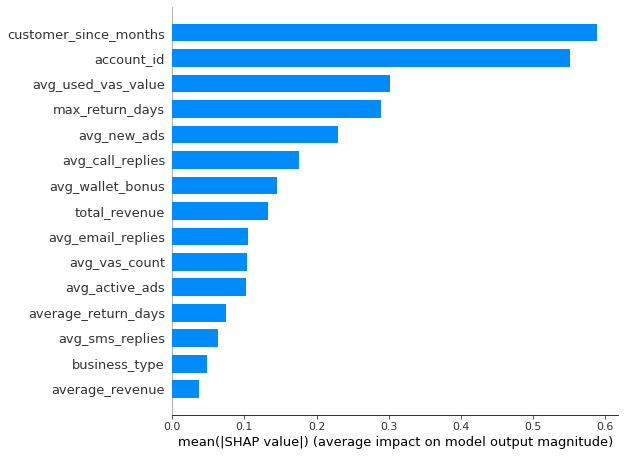

In [97]:
explainer = shap.TreeExplainer(xgb,x_test)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values=shap_values,plot_type='bar',feature_names=df.columns,class_names=y,)

In [103]:
df.columns

Index(['account_id', 'max_return_days', 'average_return_days',
       'customer_since_months', 'total_revenue', 'average_revenue',
       'avg_vas_count', 'avg_used_vas_value', 'business_type',
       'avg_wallet_bonus', 'avg_active_ads', 'avg_new_ads',
       'avg_email_replies', 'avg_call_replies', 'avg_sms_replies', 'target'],
      dtype='object')

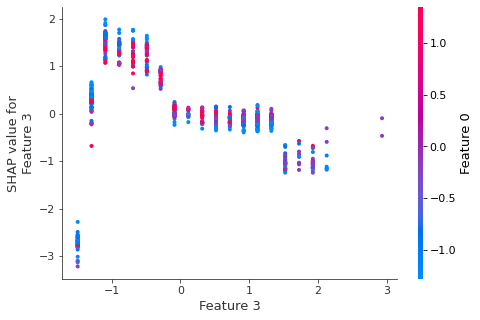

In [104]:
shap.dependence_plot(3, shap_values, x_test)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
import keras

In [25]:
def model():
  keras.backend.clear_session()
  model = Sequential()
  model.add(Dense(8,activation='relu',input_dim=15))
  model.add(Dense(4,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [26]:
model = model()

In [27]:
model.fit(x_sm,y_sm,batch_size=64,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
93/93 [==============================] - 0s 4ms/step - loss: 0.7032 - accuracy: 0.5179 - val_loss: 0.6596 - val_accuracy: 0.5518
Epoch 2/10
93/93 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6654 - val_loss: 0.6241 - val_accuracy: 0.6427
Epoch 3/10
93/93 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.7134 - val_loss: 0.6001 - val_accuracy: 0.6591
Epoch 4/10
93/93 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.7274 - val_loss: 0.5780 - val_accuracy: 0.6682
Epoch 5/10
93/93 [==============================] - 0s 3ms/step - loss: 0.5592 - accuracy: 0.7318 - val_loss: 0.5625 - val_accuracy: 0.6736
Epoch 6/10
93/93 [==============================] - 0s 3ms/step - loss: 0.5520 - accuracy: 0.7365 - val_loss: 0.5576 - val_accuracy: 0.6791
Epoch 7/10
93/93 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.7385 - val_loss: 0.5532 - val_accuracy: 0.6827
Epoch 8/10
93/93 [==

In [30]:
pred_net=model.predict_classes(x_test).reshape(-1)
recall_score(y_test,pred_net)
f1_score(y_test,pred_net)
#pred_net

0.35424354243542433